<a href="https://colab.research.google.com/github/Sharonkimani/BCG-Task/blob/main/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [45]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

---
## 2. Load data

In [2]:
df = pd.read_csv('/content/clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_sensitivity_off_peak_var,price_sensitivity_off_peak_fix
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,1,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,-17.924843,-40.000002
1,1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,1,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,-17.924843,-40.000002
2,2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,1,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,-17.924843,-40.000014


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [4]:
price_df = pd.read_csv('/content/price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [5]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
#diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,price_date,dec_1,dec_2,price_off_peak_var,price_off_peak_fix,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,2015-12-01,0.119906,40.728885,0.126098,40.565969,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,2015-12-01,0.143943,44.444710,0.148047,44.266931,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-12-01,0.201280,45.944710,0.150837,44.444710,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,2015-12-01,0.113068,40.728885,0.123086,40.565969,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,2015-12-01,0.145440,44.266930,0.149434,44.266931,-0.003994,-0.000001


## Explore Ways to Improve the Feature

1. Price Change Percentage: Calculate Percentage Change

- Objective: Calculate the percentage change in off-peak prices.
- Implementation: We'll compute the percentage change between December and January prices.
- Justification: Percentage change provides a standardized measure of price sensitivity

In [6]:
# Calculate the percentage change in off-peak prices
diff['percentage_offpeak_price_change_energy'] = ((diff['dec_1'] - diff['price_off_peak_var']) / diff['price_off_peak_var']) * 100
diff['percentage_offpeak_price_change_power'] = ((diff['dec_2'] - diff['price_off_peak_fix']) / diff['price_off_peak_fix']) * 100


In [7]:
diff.head()

,id,price_date,dec_1,dec_2,price_off_peak_var,price_off_peak_fix,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,percentage_offpeak_price_change_energy,percentage_offpeak_price_change_power
0,0002203ffbb812588b632b9e628cc38d,2015-12-01,0.119906,40.728885,0.126098,40.565969,-0.006192,0.162916,-4.910466,0.401607
1,0004351ebdd665e6ee664792efc4fd13,2015-12-01,0.143943,44.444710,0.148047,44.266931,-0.004104,0.177779,-2.772093,0.401606
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-12-01,0.201280,45.944710,0.150837,44.444710,0.050443,1.500000,33.442060,3.374980
3,0010ee3855fdea87602a5b7aba8e42de,2015-12-01,0.113068,40.728885,0.123086,40.565969,-0.010018,0.162916,-8.139025,0.401607
4,00114d74e963e47177db89bc70108537,2015-12-01,0.145440,44.266930,0.149434,44.266931,-0.003994,-0.000001,-2.672752,-0.000003




**Feature Justification: Percentage Off-Peak Price Change**

The "Percentage Off-Peak Price Change" feature is a valuable addition to our dataset as it plays a crucial role in enhancing the predictive power of our churn model. This feature quantifies the percentage change in off-peak prices between December and January of the preceding year for both energy and power. Here's why this feature is essential and how it contributes to improving our model:

1. **Measuring Price Sensitivity:** One of the fundamental drivers of customer churn is price sensitivity. By calculating the percentage change in off-peak prices, we create a standardized metric that directly reflects how sensitive customers are to price fluctuations. This measurement allows us to quantify the impact of price changes on customer behavior.

2. **Directional Insight:** The feature captures both positive and negative percentage changes in off-peak prices. These directional changes provide valuable insights into customer reactions. Customers responding to price decreases (negative changes) may exhibit different behaviors than those responding to price increases (positive changes). Understanding these distinctions can guide tailored retention strategies.

3. **Sensitivity Segmentation:** With the percentage change feature, we can segment customers based on their price sensitivity. Customers with high positive percentage changes are likely to be more price-sensitive and responsive to price increases. Conversely, those with negative or low percentage changes may be less sensitive. This segmentation allows us to customize retention efforts for different customer groups.

4. **Churn Prediction Enhancement:** Incorporating the "Percentage Off-Peak Price Change" feature into our predictive model empowers it to capture the influence of price fluctuations on churn. The feature provides the model with a data-driven indicator of customer responsiveness to price changes, improving the model's ability to identify potential churners accurately.

5. **Strategic Decision-Making:** This feature supports data-driven decision-making regarding pricing strategies and discounts. For instance, we can target customers with high positive percentage changes for special retention offers, such as the proposed 20% discount. Testing the effectiveness of such strategies on this segmented group can provide valuable insights for the client.

6. **Benchmarking and Monitoring:** Over time, this feature can serve as a benchmark for monitoring price sensitivity trends. We can analyze how customers' sensitivity to price changes evolves and adjust our strategies accordingly.

In summary, the "Percentage Off-Peak Price Change" feature is pivotal in our efforts to understand and predict customer churn. It quantifies price sensitivity, guides segmentation, enhances churn prediction, and informs strategic decisions. By providing a standardized measure of price impact, this feature significantly improves the predictive power of our model, ultimately helping us achieve our project goals more effectively.



---------------

2. Seasonal Trends: Calculate Average Off-Peak Prices for Each Season

- Objective: Calculate the average off-peak price for each season (e.g., winter, spring, summer, fall) and use the difference between the current December and the same season in the preceding year.
- Implementation: We'll group prices by season and calculate differences.
- Justification: Different seasons may have distinct price sensitivity effects.

In [8]:
# Define seasons and create a mapping of months to seasons
seasons = {
    'winter': ['12', '01', '02'],  # Use '12' for December and '01' for January
    'spring': ['03', '04', '05'],
    'summer': ['06', '07', '08'],
    'fall': ['09', '10', '11']
}
month_to_season = {month: season for season, months in seasons.items() for month in months}

# Group prices by season
monthly_price_by_id['season'] = monthly_price_by_id['price_date'].astype('str').apply(lambda x: month_to_season[x.split('-')[1]])
seasonal_prices = monthly_price_by_id.groupby(['id', 'season']).agg({
    'price_off_peak_var': 'mean',
    'price_off_peak_fix': 'mean'
}).reset_index()

# Calculate the difference for each season
for season in seasons:
    season_prices = seasonal_prices[seasonal_prices['season'] == season]
    season_diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}),
                           season_prices.drop(columns='season'), on='id')
    season_diff[f'offpeak_diff_dec_{season}_energy'] = season_diff['dec_1'] - season_diff['price_off_peak_var']
    season_diff[f'offpeak_diff_dec_{season}_power'] = season_diff['dec_2'] - season_diff['price_off_peak_fix']
    season_diff = season_diff[['id', f'offpeak_diff_dec_{season}_energy', f'offpeak_diff_dec_{season}_power']]
    # Merge the seasonal differences with the original diff DataFrame
    diff = diff.merge(season_diff, on='id', how='left')


In [9]:
diff.head()

,id,price_date,dec_1,dec_2,price_off_peak_var,price_off_peak_fix,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,percentage_offpeak_price_change_energy,percentage_offpeak_price_change_power,offpeak_diff_dec_winter_energy,offpeak_diff_dec_winter_power,offpeak_diff_dec_spring_energy,offpeak_diff_dec_spring_power,offpeak_diff_dec_summer_energy,offpeak_diff_dec_summer_power,offpeak_diff_dec_fall_energy,offpeak_diff_dec_fall_power
0,0002203ffbb812588b632b9e628cc38d,2015-12-01,0.119906,40.728885,0.126098,40.565969,-0.006192,0.162916,-4.910466,0.401607,-0.004128,1.086104e-01,-0.008161,0.000000e+00,-0.005441,0.000000e+00,0.0,0.000000e+00
1,0004351ebdd665e6ee664792efc4fd13,2015-12-01,0.143943,44.444710,0.148047,44.266931,-0.004104,0.177779,-2.772093,0.401606,-0.002736,1.185192e-01,-0.004223,1.185192e-01,-0.002975,7.105427e-15,0.0,7.105427e-15
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-12-01,0.201280,45.944710,0.150837,44.444710,0.050443,1.500000,33.442060,3.374980,0.033629,1.000000e+00,0.048232,1.500000e+00,-0.002975,7.105427e-15,0.0,7.105427e-15
3,0010ee3855fdea87602a5b7aba8e42de,2015-12-01,0.113068,40.728885,0.123086,40.565969,-0.010018,0.162916,-8.139025,0.401607,-0.006679,1.086104e-01,-0.010018,1.629156e-01,-0.006060,5.430400e-02,0.0,0.000000e+00
4,00114d74e963e47177db89bc70108537,2015-12-01,0.145440,44.266930,0.149434,44.266931,-0.003994,-0.000001,-2.672752,-0.000003,-0.002663,-8.000000e-07,-0.004306,-8.000000e-07,-0.002975,0.000000e+00,0.0,0.000000e+00




**Importance of Seasonal Features:**

Seasonal features, such as the percentage change in off-peak prices for different seasons, play a crucial role in improving the predictive power of our churn model. These features capture the variations in customer behavior and preferences that occur throughout the year. Here's why these seasonal features are important:

1. **Customer Behavior Variations:** Customers often exhibit different behaviors during various seasons of the year. For instance, energy consumption patterns may change during summer and winter due to heating or cooling needs. By considering these seasonal variations, our model can better understand and predict when customers are more likely to churn.

2. **Price Sensitivity:** Seasonal price changes can significantly impact customer decisions. For example, customers may be more price-sensitive during high-demand seasons (e.g., summer) when energy costs are typically higher. Conversely, they may be less sensitive during low-demand seasons (e.g., fall). The percentage change in off-peak prices for each season helps quantify this price sensitivity.

3. **Tailored Marketing Strategies:** With knowledge of how customers respond to seasonal price changes, our client can develop tailored marketing and retention strategies. For instance, they can offer targeted promotions or discounts during seasons when customers are more likely to churn, thereby reducing churn rates and retaining valuable customers.

4. **Model Generalization:** Including seasonal features enhances the generalization ability of our model. Instead of assuming a constant customer behavior pattern throughout the year, the model can adapt its predictions based on seasonal trends. This adaptability improves the accuracy of churn predictions, especially when dealing with diverse customer bases.

5. **Data-Driven Insights:** Seasonal features provide valuable insights into when and why customers are most susceptible to churn. This information can guide data-driven decision-making, allowing the client to proactively address churn risks during specific seasons.

6. **Evaluation of Discount Strategies:** If the client intends to implement a 20% discount strategy for customers at high propensity to churn, seasonal features can help assess the effectiveness of this strategy. By analyzing how customers respond to discounts during different seasons, the client can fine-tune their discounting approach for maximum impact.

In summary, the newly generated seasonal features, which calculate the percentage change in off-peak prices for different seasons, offer a deeper understanding of customer behavior and price sensitivity throughout the year. These features enhance the predictive power of our churn model and enable the client to make data-driven decisions to reduce churn and optimize their business strategies.

In [10]:
diff.drop(['price_date', 'dec_1' , 'dec_2' , 'price_off_peak_var', 'price_off_peak_fix'], axis=1, inplace=True)

In [11]:
diff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16096 entries, 0 to 16095
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      16096 non-null  object 
 1   offpeak_diff_dec_january_energy         16096 non-null  float64
 2   offpeak_diff_dec_january_power          16096 non-null  float64
 3   percentage_offpeak_price_change_energy  16074 non-null  float64
 4   percentage_offpeak_price_change_power   15977 non-null  float64
 5   offpeak_diff_dec_winter_energy          16096 non-null  float64
 6   offpeak_diff_dec_winter_power           16096 non-null  float64
 7   offpeak_diff_dec_spring_energy          16093 non-null  float64
 8   offpeak_diff_dec_spring_power           16093 non-null  float64
 9   offpeak_diff_dec_summer_energy          16095 non-null  float64
 10  offpeak_diff_dec_summer_power           16095 non-null  fl

In [12]:
missing_data = diff.isnull().sum()
missing_percentage = (missing_data / len(diff)) * 100
missing_percentage

id                                        0.000000
offpeak_diff_dec_january_energy           0.000000
offpeak_diff_dec_january_power            0.000000
percentage_offpeak_price_change_energy    0.136680
percentage_offpeak_price_change_power     0.739314
offpeak_diff_dec_winter_energy            0.000000
offpeak_diff_dec_winter_power             0.000000
offpeak_diff_dec_spring_energy            0.018638
offpeak_diff_dec_spring_power             0.018638
offpeak_diff_dec_summer_energy            0.006213
offpeak_diff_dec_summer_power             0.006213
offpeak_diff_dec_fall_energy              0.000000
offpeak_diff_dec_fall_power               0.000000
dtype: float64

In [13]:
'''
the  columns with missing values have less than 1% missing values thus we can impute them.
we'll impute them using the median since imputing with the mean might skew the data
'''
def impute_missing_values(df, columns_to_impute):
    """
    Impute missing values in the specified columns with their respective medians.

    Parameters:
        df (DataFrame): The DataFrame containing the columns to impute.
        columns_to_impute (list): A list of column names to impute.

    Returns:
        DataFrame: The DataFrame with missing values imputed.
    """
    for column in columns_to_impute:
        median_value = df[column].median()
        df[column].fillna(median_value, inplace=True)

    return df

# List of columns to impute
columns_to_impute = [
    'percentage_offpeak_price_change_energy',
    'percentage_offpeak_price_change_power', 'offpeak_diff_dec_spring_energy', 'offpeak_diff_dec_spring_power',
    'offpeak_diff_dec_summer_energy', 'offpeak_diff_dec_summer_power']

# Call the function to impute missing values
diff = impute_missing_values(diff, columns_to_impute)

In [14]:
missing_data = diff.isnull().sum()
missing_percentage = (missing_data / len(diff)) * 100
missing_percentage

id                                        0.0
offpeak_diff_dec_january_energy           0.0
offpeak_diff_dec_january_power            0.0
percentage_offpeak_price_change_energy    0.0
percentage_offpeak_price_change_power     0.0
offpeak_diff_dec_winter_energy            0.0
offpeak_diff_dec_winter_power             0.0
offpeak_diff_dec_spring_energy            0.0
offpeak_diff_dec_spring_power             0.0
offpeak_diff_dec_summer_energy            0.0
offpeak_diff_dec_summer_power             0.0
offpeak_diff_dec_fall_energy              0.0
offpeak_diff_dec_fall_power               0.0
dtype: float64

##Modelling

In [20]:
data= df.merge(diff,on='id', how='inner')
data.drop(['Unnamed: 0','id'],axis=1, inplace=True)

In [25]:
data["price_date"] = pd.to_datetime(data["price_date"], format='%Y-%m-%d')
data.select_dtypes(include='object')
col=['channel_sales','has_gas','origin_up']



In [26]:

def check_value_counts(data, col):
  for column in col:
    print(f'value counts for {column}')
    print(data[column].value_counts())
    print('------------------------------------------','\n')

check_value_counts(data, col)

value counts for channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    80971
MISSING                             44684
lmkebamcaaclubfxadlmueccxoimlema    22105
usilxuppasemubllopkaafesmlibmsdf    16486
ewpakwlliwisiwduibdlfmalxowmwpci    10712
sddiedcslfslkckwlfkdpoeeailfpeds      131
epumfxlbckeskwekxbiuasklxalciiuu       36
fixdbufsefwooaasfcxdxadsiekoceaa       24
Name: channel_sales, dtype: int64
------------------------------------------ 

value counts for has_gas
f    143364
t     31785
Name: has_gas, dtype: int64
------------------------------------------ 

value counts for origin_up
lxidpiddsbxsbosboudacockeimpuepw    85086
kamkkxfxxuwbdslkwifmmcsiusiuosws    51503
ldkssxwpmemidmecebumciepifcamkci    37757
MISSING                               767
usapbepcfoloekilkwsdiboslwaxobdp       24
ewxeelcelemmiwuafmddpobolfuxioce       12
Name: origin_up, dtype: int64
------------------------------------------ 



## Transforming categorical variables


In [33]:
from sklearn.preprocessing import OrdinalEncoder # transforming the column with 2 categories
#df= data[['has_gas']]
encoder= OrdinalEncoder()
data[['has_gas']]= encoder.fit_transform(data[['has_gas']])
encoder.categories_[0]##to know which variable is 0 and which one is 1


array(['f', 't'], dtype=object)

'f' is 0 and 't' is 1

In [44]:
from sklearn.preprocessing import OneHotEncoder

# Select the columns to one-hot encode
columns_to_encode = ['origin_up', 'channel_sales']
df_to_encode = data[columns_to_encode]

# Initialize the OneHotEncoder
ohe = OneHotEncoder()

# Fit and transform the data
encoded_data = ohe.fit_transform(df_to_encode)

# Create a new DataFrame with appropriate column names
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=ohe.get_feature_names_out(columns_to_encode), index=data.index)
data.drop(['origin_up', 'channel_sales'], axis=1, inplace= True)
new_data= pd.concat([encoded_df, data], axis=1)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175149 entries, 0 to 175148
Data columns (total 58 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   origin_up_MISSING                               175149 non-null  float64       
 1   origin_up_ewxeelcelemmiwuafmddpobolfuxioce      175149 non-null  float64       
 2   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws      175149 non-null  float64       
 3   origin_up_ldkssxwpmemidmecebumciepifcamkci      175149 non-null  float64       
 4   origin_up_lxidpiddsbxsbosboudacockeimpuepw      175149 non-null  float64       
 5   origin_up_usapbepcfoloekilkwsdiboslwaxobdp      175149 non-null  float64       
 6   channel_sales_MISSING                           175149 non-null  float64       
 7   channel_sales_epumfxlbckeskwekxbiuasklxalciiuu  175149 non-null  float64       
 8   channel_sales_ewpakwlliwisiwduibdl

Before modelling, our data had class imbalance problems, we'll use SMOTE to help with this but first we need to split our data into X and y and also train test split the data.



In [55]:
data_frame= new_data.select_dtypes(exclude='datetime64[ns]')
data_frame.drop(['percentage_offpeak_price_change_energy' , 'percentage_offpeak_price_change_power'], axis=1, inplace= True)
#removing the two columns because they contain infinite and large values
y=data_frame['churn']
X= data_frame.drop('churn', axis=1)

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=20)


# Set the random seed
random_seed = 42
np.random.seed(random_seed)
# smote
smote= SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

y_train_resampled.value_counts()

0    110752
1    110752
Name: churn, dtype: int64

The class imbalance problems have been resolved and the predictor variables are on the same scale thus the data is fit for modelling.

In [57]:
##baseline model
rf=RandomForestClassifier(random_state=20)# fitting a baseline model with default hyperparameters
rf.fit(X_train_resampled,y_train_resampled)
print(rf.score(X_train_resampled,y_train_resampled))#accuracy for training set
print(rf.score(X_test,y_test))#accuracy for testing set


1.0
0.999505186031021


In [58]:
rf.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 20,
 'verbose': 0,
 'warm_start': False}

The baseline model has an accuracy of 100% for the training set and 99.95% for the testing set which is pretty good implying that the model is not overfitting. Let's try tuning the hyperparameters to see if we can improve the testing accuracy

In [59]:
grid = {"criterion":["gini" , "entropy"],
        "max_depth":[ None, 2, 3],
        'min_samples_split':[2, 5, 10],
        "min_samples_leaf":[1, 2, 3]}

def tuning_parameters(model,grid):
  gridsearch=GridSearchCV(model, param_grid= grid, cv=5)
  gridsearch.fit(X_train_resampled,y_train_resampled)
  print(gridsearch.score(X_train_resampled,y_train_resampled))
  print(gridsearch.score(X_test,y_test))
  return gridsearch

rf_model=tuning_parameters(rf,grid)
rf_model

1.0
0.9995622799505186


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=20),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 5, 10]})

In [60]:
rf_model.best_params_


{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [65]:
model=RandomForestClassifier(criterion = 'entropy', max_depth = None,
                             min_samples_leaf = 1, min_samples_split = 2 ,
                             random_state=20)# fitting a baseline model with default hyperparameters
model.fit(X_train_resampled,y_train_resampled)

RandomForestClassifier(criterion='entropy', random_state=20)

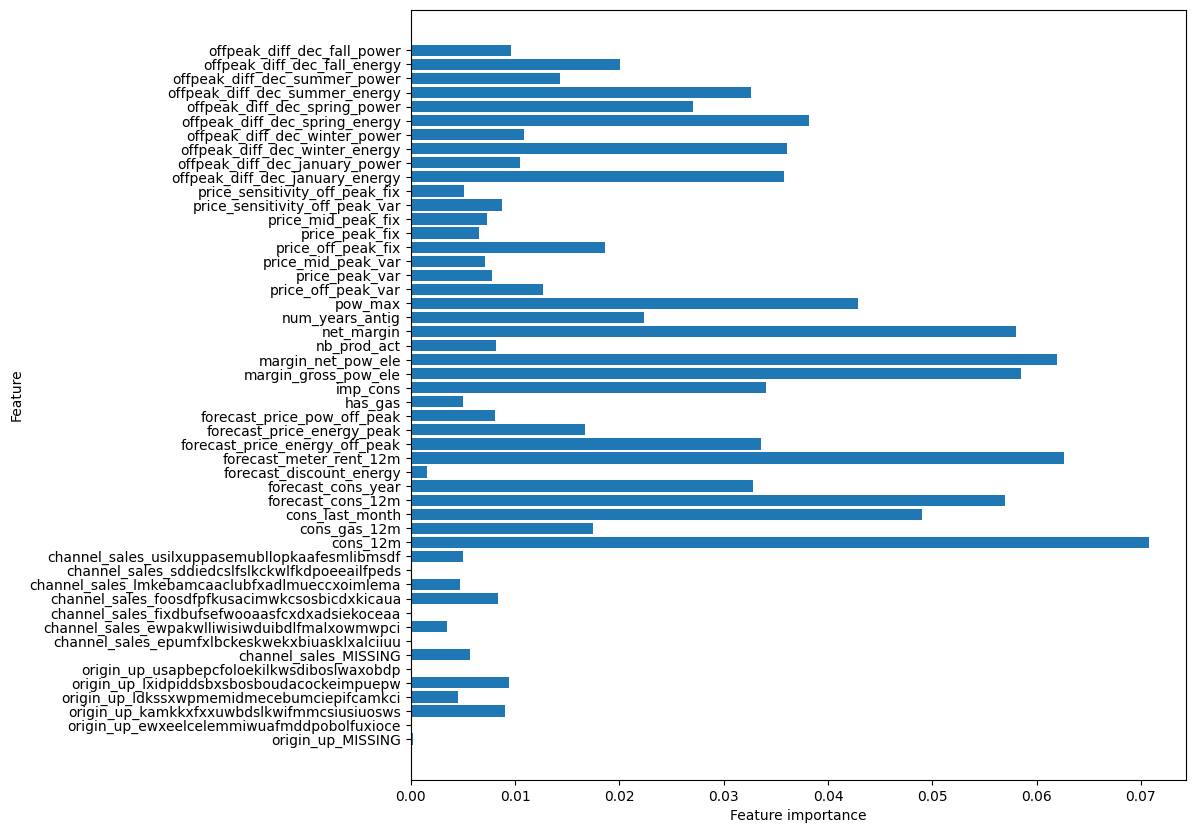

In [66]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10,10))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns.values)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(model)

The horizontal bars represent the importance of each feature, with longer bars indicating higher importance. The y-axis displays the feature names.This visualization helps identify the most influential features in the random forest model, allowing you to understand which features have the greatest impact on the model's predictions.



The most important feature is electricity consumption of the past 12 months

The best random forest model uses entropy criterion, has 100% accuracy on training set and 99.96% on testing set.

## evaluation

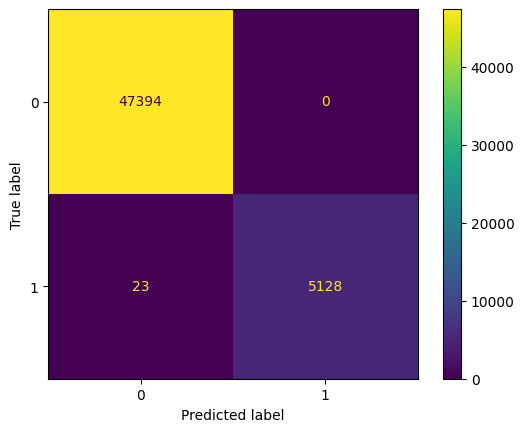

In [68]:
pred= model.predict(X_test)

cf=confusion_matrix(y_test,pred)
disp=ConfusionMatrixDisplay(cf)
disp.plot()
plt.show();

The model has 5128 true positives, 47394 true negatives, 23 false negatives and 0 false positives. Let's use evaluation metrics to evaluate the performance of our final model.

In [69]:
print(classification_report(y_test,pred))

def evaluation_metrics(y_test, y_pred):
  print('accuracy:',{accuracy_score(y_test, y_pred)})
  print('precision:',{precision_score(y_test, y_pred)})
  print('recall:',{recall_score(y_test, y_pred)})
  print('f1_score:',{f1_score(y_test, y_pred)})

evaluation_metrics(y_test, pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     47394
           1       1.00      1.00      1.00      5151

    accuracy                           1.00     52545
   macro avg       1.00      1.00      1.00     52545
weighted avg       1.00      1.00      1.00     52545

accuracy: {0.9995622799505186}
precision: {1.0}
recall: {0.9955348476024073}
f1_score: {0.9977624282517754}


The model :

-Has an accuracy of 99.96% ie out of 100 customers, it correctly predicts the class almost all of them ,churn or not churn.
- Has a precision of 100% meaning out of the predicted positives( customers likely to churn), the model correctly predicted all of them
- Has a recall of 99.6% meaning, out of the actual positives,(the customers that did churn), the model correctly predicted 99.6% of them
- Has an f1 score of 99.8% ie the model has a good balance between precision and recall. It means that the model is effectively identifying the positive class instances while minimizing false positives and false negatives.

## Advantages and disadvantages of using random forest
1. **Advantages:**

- High Accuracy: Random Forests are known for their ability to provide accurate predictions, making them suitable for classification tasks like customer churn prediction.

- Robust to Overfitting: Random Forests are less prone to overfitting compared to individual decision trees. They can handle noise and outliers well.

- Feature Importance: Random Forests provide feature importance scores, helping you identify which features are most influential in making predictions.

- Handles Nonlinear Relationships: Random Forests can capture complex, nonlinear relationships in the data, which can be essential for accurate churn prediction.

- Works with Imbalanced Data: Techniques like SMOTE can be applied to address class imbalance, as done in the analysis.

2. **Disadvantages:**

- Lack of Interpretability: Random Forests are often considered "black-box" models, making it challenging to interpret the decision-making process.

- Computationally Intensive: Training Random Forests can be computationally intensive, especially when dealing with large datasets or a high number of trees.

- Hyperparameter Tuning: Tuning the hyperparameters of a Random Forest can be time-consuming, as it involves searching over a wide range of options.

- Model Complexity: Random Forests consist of multiple decision trees, which can result in a complex ensemble model.

- Potential Overfitting: While Random Forests are less prone to overfitting, it's still possible, especially if the model is not properly tuned.

------
Based on the results above and the nature of the problem, it's best to represent this problem as a classification task. Specifically, it's a binary classification problem where the goal is to predict whether a customer will churn (1) or not churn (0).

In terms of model performance, the choice of appropriate metrics depends on the specific business goals and the trade-offs between different types of errors. Here are some key performance metrics to consider:

1. **Accuracy**: This is a basic metric that measures the overall correctness of the model's predictions. It's suitable when the cost of false positives and false negatives is roughly equal.

2. **Precision and Recall**: These metrics are useful for imbalanced datasets like yours. Precision measures the proportion of true positives among all positive predictions, while recall measures the proportion of true positives among all actual positives. You might want to focus on recall if reducing false negatives (missing potential churners) is more critical for your business.

3. **F1-Score**: The F1-Score is the harmonic mean of precision and recall, which balances the trade-off between false positives and false negatives. It can be a good overall measure of model performance.

5. **Confusion Matrix**: This is not a single metric but a valuable tool to analyze the performance of your classification model. It provides insights into the number of true positives, true negatives, false positives, and false negatives.

To tie business metrics such as profits or savings to model performance, you can follow these steps:

1. **Cost-Benefit Analysis**: Calculate the potential costs associated with false positives and false negatives. For example, a false positive (predicting a customer will churn when they won't) might result in unnecessary retention efforts, while a false negative (missing an actual churner) could lead to lost revenue.

2. **Threshold Selection**: Depending on the business's priorities, you can choose an appropriate probability threshold for classification. If reducing false negatives is more critical, you might set a lower threshold to capture more potential churners.

3. **Model Deployment**: Implement your classification model in your business processes. Monitor its predictions and collect real-world data on the outcomes (whether the customer actually churned or not).

4. **Evaluate Business Impact**: Over time, assess the actual impact of your model on business metrics such as customer retention, profits, or savings. Compare these metrics to the baseline (before model implementation) to quantify the model's effectiveness.

5. **Iterate and Refine**: Continuously refine your model based on its performance and its impact on business metrics. You can retrain the model with new data and potentially adjust the threshold as business priorities change.

By measuring and tying model performance to business metrics, you can ensure that the classification model provides tangible value to your organization in terms of customer retention and profitability.